# Lab 3 Report: 
## MNIST Classification with FCN

### Name: Zachary Banken 

In [5]:
# Import necessary packages

%matplotlib inline

import matplotlib.pyplot as plt

import torch
import numpy as np

In [6]:
from IPython.display import Image # For displaying images in colab jupyter cell

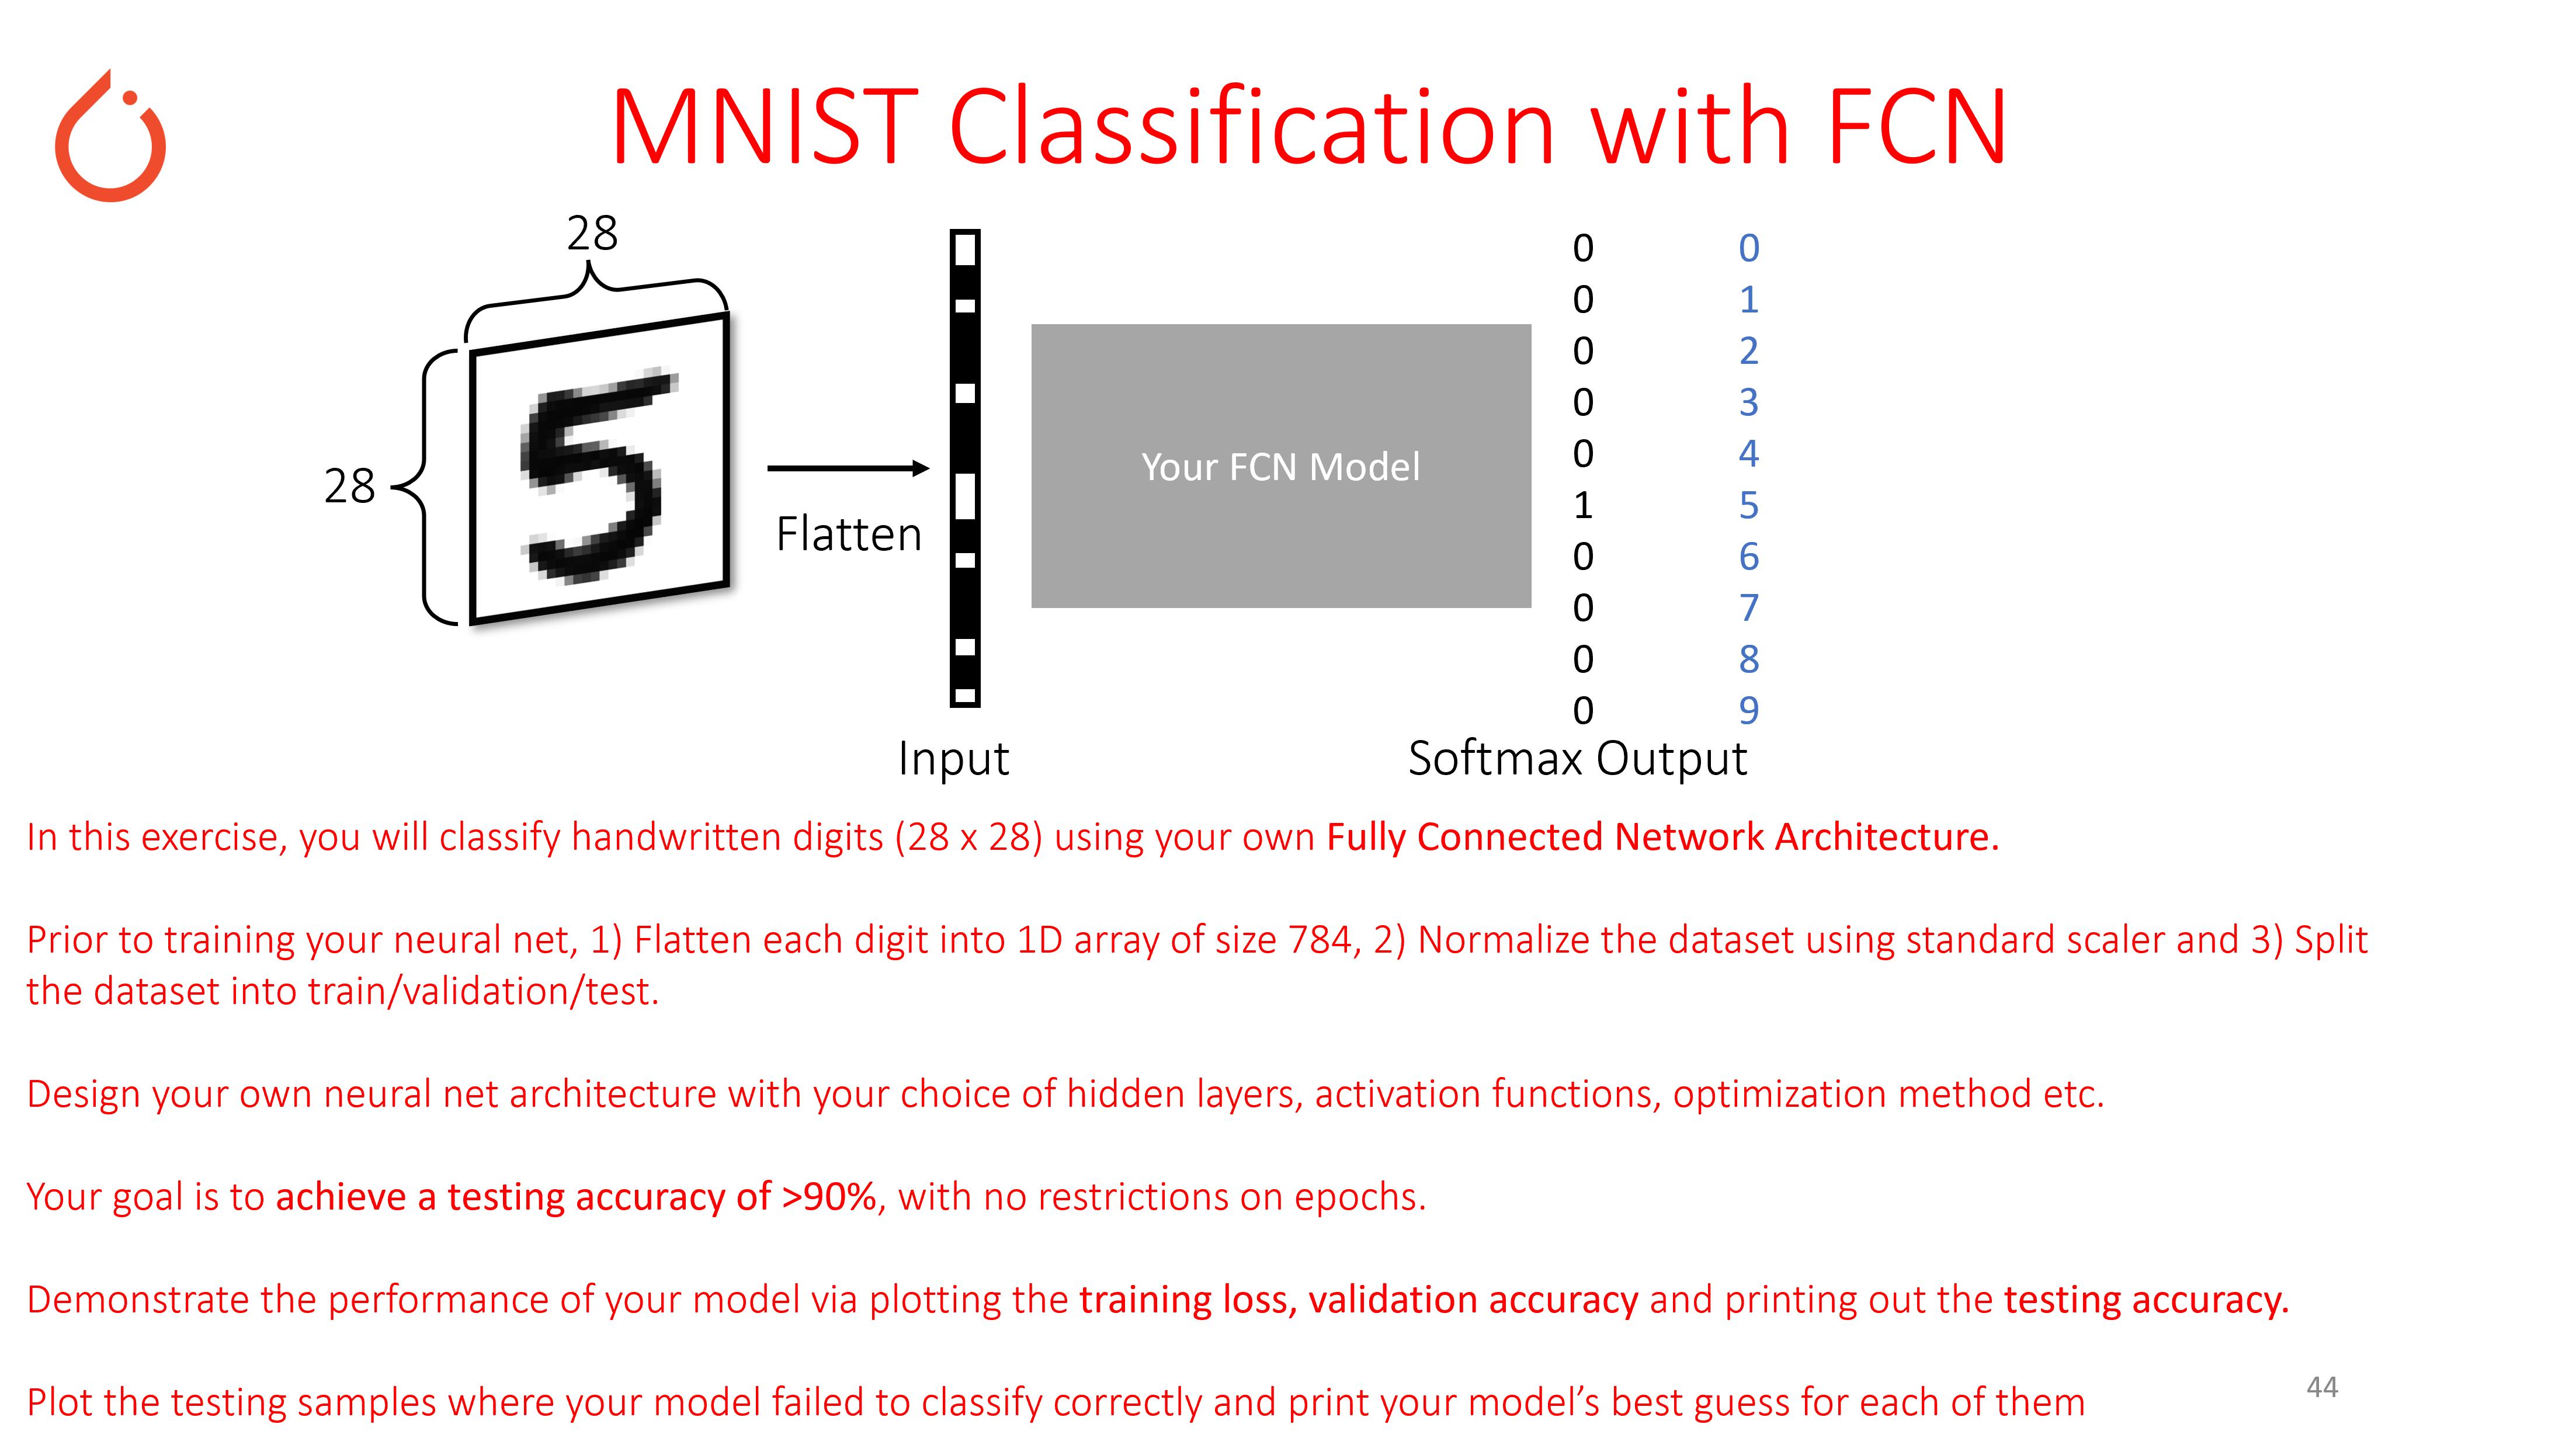

In [7]:
Image('lab3_exercise.PNG', width = 1000)

### Prepare Data

In [51]:
# Load MNIST Dataset in Numpy

# 1000 training samples where each sample feature is a greyscale image with shape (28, 28)
# 1000 training targets where each target is an integer indicating the true digit
mnist_train_features = np.load('mnist_train_features.npy') 
mnist_train_targets = np.load('mnist_train_targets.npy')

# 100 testing samples + targets
mnist_test_features = np.load('mnist_test_features.npy')
mnist_test_targets = np.load('mnist_test_targets.npy')

# Print the dimensions of training sample features/targets
print(mnist_train_features.shape, mnist_train_targets.shape)
# Print the dimensions of testing sample features/targets
print(mnist_test_features.shape, mnist_test_targets.shape)

(1000, 28, 28) (1000,)
(100, 28, 28) (100,)


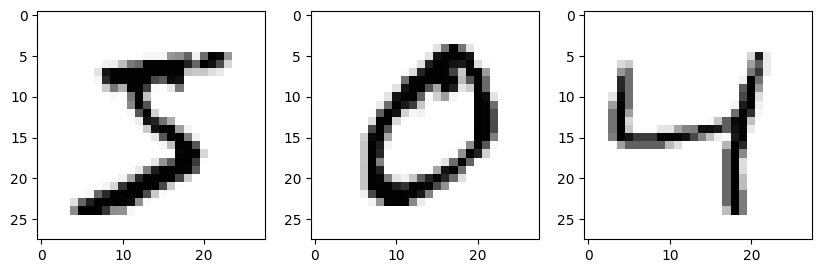

In [52]:
# Let's visualize some training samples

plt.figure(figsize = (10, 10))

plt.subplot(1,3,1)
plt.imshow(mnist_train_features[0], cmap = 'Greys')

plt.subplot(1,3,2)
plt.imshow(mnist_train_features[1], cmap = 'Greys')

plt.subplot(1,3,3)
plt.imshow(mnist_train_features[2], cmap = 'Greys')

In [53]:
# Scale the dataset using standard scaling

# flatten images
nsamples = mnist_train_features.shape[0]
ntests = mnist_test_features.shape[0]
mnist_train_features = mnist_train_features.reshape((nsamples, 28*28))
mnist_test_features = mnist_test_features.reshape((ntests, 28*28))

# scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# compute std and mean of training data, transform training data
mnist_train_features = scaler.fit_transform(mnist_train_features)
# transform testing data using fit on training data
mnist_test_features = scaler.transform(mnist_test_features)

In [54]:
# Split the training set into training and validation sets
from sklearn.model_selection import train_test_split
mnist_train_features, mnist_validation_features, mnist_train_targets, mnist_validation_targets = \
      train_test_split(mnist_train_features, mnist_train_targets, test_size = 0.1, random_state = 42)

print(mnist_train_features.shape, mnist_test_features.shape, mnist_validation_features.shape)

(900, 784) (100, 784) (100, 784)


### Define Model

In [321]:
class mnistClassification(torch.nn.Module):
    
    def __init__(self, input_dim, output_dim): # Feel free to add hidden_dim as parameters here
        
        super(mnistClassification, self).__init__()

        self.bn1 = torch.nn.BatchNorm1d(input_dim)
        self.layer1 = torch.nn.Linear(input_dim, 50)
        self.layer2 = torch.nn.Linear(50, 25)
        self.layer3 = torch.nn.Linear(25, output_dim)
        
        
    def forward(self, x):
        #batch normalization on x
        x = self.bn1(x)
        out1 = torch.nn.functional.relu(self.layer1(x))
        out2 = torch.nn.functional.relu(self.layer2(out1))
        out3 = torch.nn.functional.softmax(self.layer3(out2), dim=1)
    
        return out3

### Define Hyperparameters

In [360]:
# Initialize our neural network model with input and output dimensions
model = mnistClassification(28*28, 10)

# Define the learning rate and epoch 
learning_rate = 0.001
epochs = 50
batchsize = 10

# Define loss function and optimizer
loss_func = torch.nn.CrossEntropyLoss()
#Adam with weight decay
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay = 1e-3)

# Run this line if you have PyTorch GPU version
if torch.cuda.is_available():
    model.cuda()

model

mnistClassification(
  (bn1): BatchNorm1d(784, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Linear(in_features=784, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=25, bias=True)
  (layer3): Linear(in_features=25, out_features=10, bias=True)
)

### Identify Tracked Values

In [361]:
# Placeholders for training loss and validation accuracy during training
# Training loss should be tracked for each iteration (1 iteration -> single forward pass to the network)
# Validation accuracy should be evaluated every 'Epoch' (1 epoch -> full training dataset)
# If using batch gradient, 1 iteration = 1 epoch

train_loss_list = np.zeros((epochs))
validation_accuracy_list = np.zeros((epochs))

### Train Model

In [362]:
import tqdm

# Convert the training, validation, testing dataset (NumPy arrays) into torch tensors
X_train = torch.from_numpy(mnist_train_features).float()
Y_train = torch.from_numpy(mnist_train_targets).long()

X_validation = torch.from_numpy(mnist_validation_features).float()
Y_validation = torch.from_numpy(mnist_validation_targets).long()

X_test = torch.from_numpy(mnist_test_features).float()
Y_test = torch.from_numpy(mnist_test_targets).long()

# YOUR CODE HERE

# Training Loop ---------------------------------------------------------------------------------------

# based on https://stackoverflow.com/questions/45113245/how-to-get-mini-batches-in-pytorch-in-a-clean-and-efficient-way
for epoch in tqdm.trange(epochs):
    
    # Shuffle the data
    permutation = torch.randperm(X_train.size()[0])

    for i in range(0, X_train.size()[0], batchsize):
        optimizer.zero_grad()

        # Get the batch
        indices = permutation[i:i+batchsize]
        batch_x, batch_y = X_train[indices], Y_train[indices]

        # Forward pass
        outputs = model.forward(batch_x)
        loss = loss_func(outputs,batch_y)

        # Backward pass
        loss.backward()
        optimizer.step()
    train_loss_list[epoch] = loss.item()
    
    # Compute Validation Accuracy ----------------------------------------------------------------------
    with torch.no_grad():
        
        #Calculate the validation outputs
        validation_outputs = model(X_validation)

        #Calculate the accuracy
        correct = (torch.argmax(validation_outputs, dim=1) == Y_validation).type(torch.FloatTensor)
        validation_accuracy_list[epoch] = correct.mean()

    


100%|██████████| 50/50 [00:07<00:00,  6.57it/s]


### Visualize and Evaluate Model

In [363]:
# Import seaborn for prettier plots

import seaborn as sns

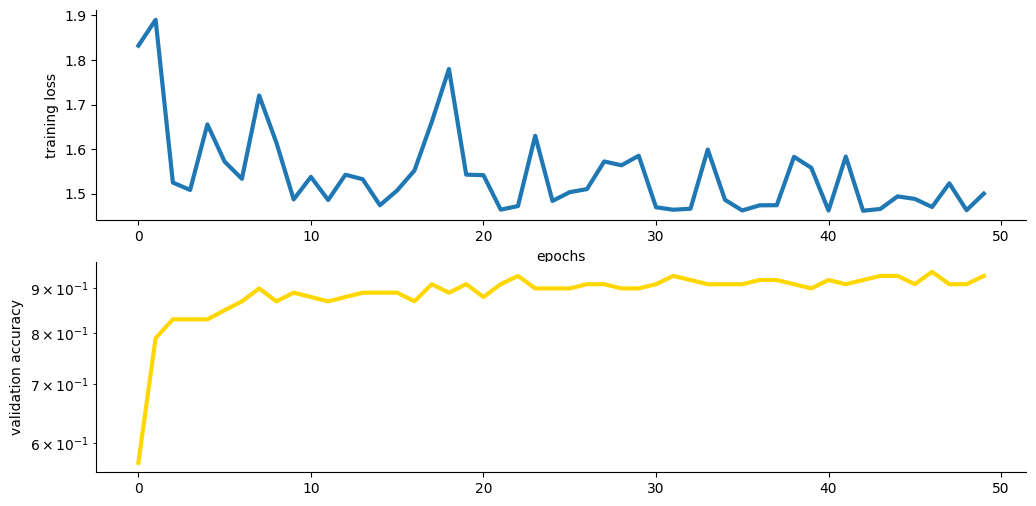

In [364]:
# Visualize training loss

plt.figure(figsize = (12, 6))

# Visualize training loss with respect to iterations (1 iteration -> single batch)
plt.subplot(2, 1, 1)
plt.plot(train_loss_list, linewidth = 3)
plt.ylabel("training loss")
plt.xlabel("epochs")
sns.despine()

# Visualize validation accuracy with respect to epochs
plt.subplot(2, 1, 2)
plt.plot(validation_accuracy_list, linewidth = 3, color = 'gold')
plt.ylabel("validation accuracy")
plt.yscale('log')
sns.despine()

In [365]:
# Compute the testing accuracy 

with torch.no_grad():
    test_outputs = model(X_test)
    correct = (torch.argmax(test_outputs, dim=1) == Y_test).type(torch.FloatTensor)
    print("Testing accuracy: ", correct.mean().item())

Testing accuracy:  0.9300000071525574


Text(0.5, 1.0, '2')

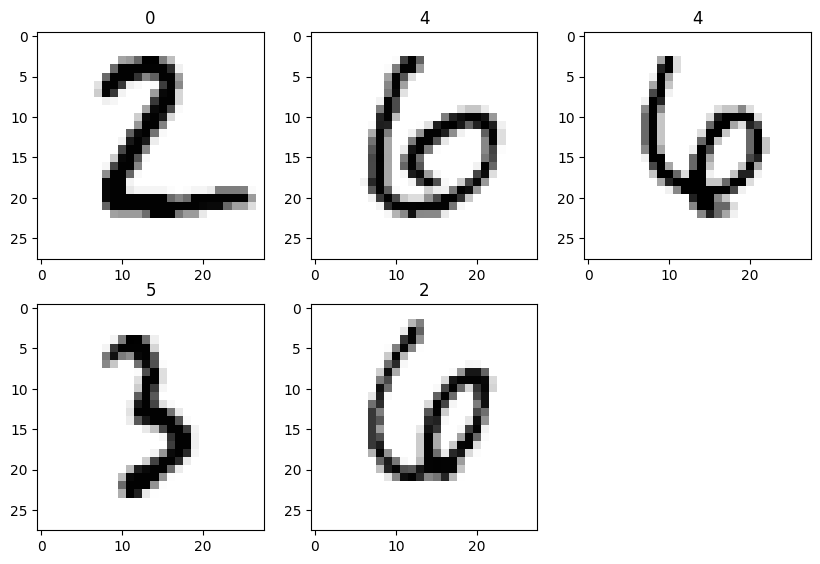

In [373]:
# Plot 5 incorrectly classified testing samples and print the model predictions for each of them
# You can use np.reshape() to convert flattened 1D array back to 2D array

incorrect_indices = np.where(torch.argmax(test_outputs, dim=1) != Y_test)[0]
incorrectly_classified = scaler.inverse_transform((X_test[incorrect_indices[0:5]]))

incorrectly_classified = (incorrectly_classified.reshape(5, 28, 28))
incorrectly_classication = model(torch.from_numpy(incorrectly_classified.reshape(5, 28*28)).float())
incorrectly_classication = torch.argmax(incorrectly_classication, dim=1).numpy()

plt.figure(figsize = (10, 10))

plt.subplot(3,3,1)
plt.imshow(incorrectly_classified[0], cmap = 'Greys')
plt.title(incorrectly_classication[0])

plt.subplot(3,3,2)
plt.imshow(incorrectly_classified[1], cmap = 'Greys')
plt.title(incorrectly_classication[1])

plt.subplot(3,3,3)
plt.imshow(incorrectly_classified[2], cmap = 'Greys')
plt.title(incorrectly_classication[2])

plt.subplot(3,3,4)
plt.imshow(incorrectly_classified[3], cmap = 'Greys')
plt.title(incorrectly_classication[3])

plt.subplot(3,3,5)
plt.imshow(incorrectly_classified[4], cmap = 'Greys')
plt.title(incorrectly_classication[4])
